In [2]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
data = pd.read_csv('/content/drive/MyDrive/news_tweets_cleaned_2.csv',encoding='latin1')
selected_columns = data[["Tweet_english"]]
df = selected_columns.copy()
df.drop(df[df['Tweet_english'].str.startswith('RT')].index,inplace = True)
print(df)
tweet_list=list(df['Tweet_english'])
print(len(tweet_list))
print("df_sample Created")

                                          Tweet_english
0     australia nears omicron peak as daily infectio...
1     indias covid vaccination coverage crosses  crore 
2      covid delhi records  cases  deaths testing low  
3     covid  west bengal registers  fresh cases amp ...
4     corona is a unique virus as it has a very high...
...                                                 ...
2007  worldbank suspends funding of projects in afgh...
2008  g leaders issued joint statement on afghanista...
2009  weve helped evacuate  people from afghanistan ...
2010  key face of antitaliban axis issues a warning ...
2011  newsalert  taliban panel meets chinese envoy t...

[2012 rows x 1 columns]
2012
df_sample Created


In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from numpy import around
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
vectorizer=TfidfVectorizer(max_features=100)
vectorizer.fit(df.Tweet_english)
result=vectorizer.transform(df.Tweet_english)
result=result.toarray()


In [4]:
from keras.preprocessing.text import Tokenizer
import gensim
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df.Tweet_english)
tokenized_documents=tokenizer.texts_to_sequences(df.Tweet_english)
tokenized_paded_documents=pad_sequences(tokenized_documents,maxlen=20,padding='post')
vocab_size=len(tokenizer.word_index)+1
print (tokenized_paded_documents[100])
print(len(tokenized_paded_documents[1]))

[ 184   10  839  130  359    9  202  240   20   76  186  977   98 1238
    0    0    0    0    0    0]
20


In [6]:
import gensim
W2V_PATH="/content/drive/MyDrive/GoogleNews-vectors-negative300.bin"
model_w2v = gensim.models.KeyedVectors.load_word2vec_format(W2V_PATH, binary=True)

In [7]:
# creating embedding matrix, every row is a vector representation from the vocabulary indexed by the tokenizer index. 
embedding_matrix=np.zeros((vocab_size,300))
print(np.size(embedding_matrix))

for word,i in tokenizer.word_index.items():
    if word in model_w2v:
        embedding_matrix[i]=model_w2v[word]
# creating document-word embeddings
document_word_embeddings=np.zeros((len(tokenized_paded_documents),20,300))
for i in range(len(tokenized_paded_documents)):
    for j in range(len(tokenized_paded_documents[0])):
        document_word_embeddings[i][j]=embedding_matrix[tokenized_paded_documents[i][j]]
print(document_word_embeddings.shape)
print(len(document_word_embeddings))


1610100
(2012, 20, 300)
2012


In [8]:
# calculating average of word vectors of a document weighted by tf-idf
document_embeddings=np.zeros((len(tokenized_paded_documents),300))
words=vectorizer.get_feature_names()
print(type(words))
print(len(words))
for i in range(len(document_word_embeddings)):
    for j in range(len(words)):
        document_embeddings[i]+=embedding_matrix[tokenizer.word_index[words[j]]]*result[i][j]
        
print (document_embeddings.shape)
#print(document_embeddings[3])
#pairwise_similarities=cosine_similarity(document_embeddings)
#pairwise_differences=euclidean_distances(document_embeddings)
#most_similar(0,pairwise_similarities,'Cosine Similarity')
#most_similar(0,pairwise_differences,'Euclidean Distance')

<class 'list'>
100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(2012, 300)


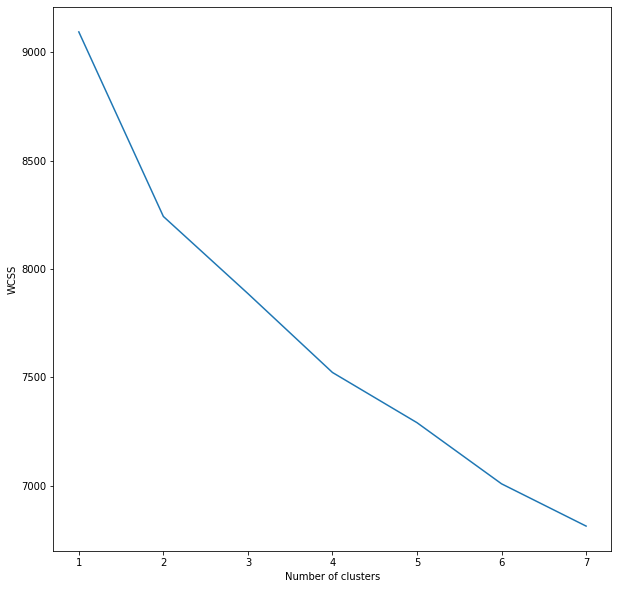

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
wcss = []
for i in range(1,8):
   model = KMeans(n_clusters = i, init = "k-means++")
   model.fit(document_embeddings)
   wcss.append(model.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,8), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [10]:
pca = PCA(2)
data = pca.fit_transform(document_embeddings)

[1 1 0 ... 0 0 0]


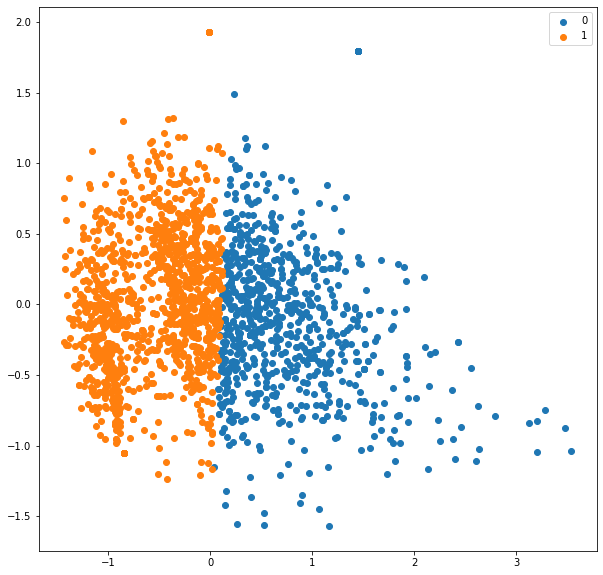

In [11]:
#centers = np.array(model.cluster_centers_)

model = KMeans(n_clusters = 2, init = "k-means++")
label = model.fit_predict(data)
print(label)
plt.figure(figsize=(10,10))
uniq = np.unique(label)
for i in uniq:
   plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
#plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')

plt.legend()
plt.show()

In [12]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
score = silhouette_score(data, label)
print("silhouette score is {})".format(round(score,2)))
print("DB Score: %0.3f"
      % davies_bouldin_score(data, label))

silhouette score is 0.38)
DB Score: 1.007


In [13]:
cluster_df=pd.DataFrame(list(zip(tweet_list, label)),
              columns=['Tweet','Cluster'])
df0 = cluster_df[cluster_df['Cluster'] == 0]
df1 = cluster_df[cluster_df['Cluster'] == 1]
#df2 = cluster_df[cluster_df['Cluster'] == 2]

print(df0.shape)
print(df1.shape)
#print(df2.shape)

cluster_df.to_csv("tweet_cluster_w2v.csv")

(838, 2)
(1174, 2)


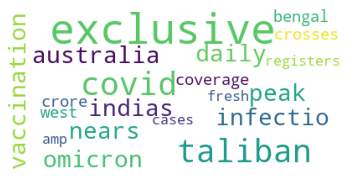

In [14]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
#% matplotlib inline
corpus=df1['Tweet']
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=STOPWORDS,
                          max_words=20,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)